In [2]:
import EPUtils
import gdas
from datetime import datetime, timedelta
import numpy as np
import numpy.ma as ma
import scipy.optimize as opt
import matplotlib.pyplot as plt
import random


import copy
import pickle
import time
import os
from scipy.constants import *

/home/stalnakerlab/anaconda3/envs/axion_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/stalnakerlab/anaconda3/envs/axion_env/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin 

In [3]:
STATION_STANDARD_DEVIATIONS = {
    'berkeley02': 2.0,
    'berkeley01': 4.0,
    'daejeon01': 0.2,
    'hayward01': 0.1,
    'krakow01': 0.8,
    'lewisburg01': 0.1,
    'mainz01': 0.1,
    'losangeles01': 1.5,
    'moxa01': 1.0,
    'oberlin01': 0.2
}

STATION_SENSITIVE_AXES = { # in form: longitude, long direction?, lattitude, lat direction?, azimuth, altitude
    'beijing01': (116.1868,'E',40.2457,'N',251,0),
    'berkeley02': (122.2570,'W',37.8723,'N',0,90),
    'canberra01': (149.1185,'E',35.2745,'S',0,90),
    'daejeon01': (127.3987,'E',36.3909,'N',0,90),
    'hayward01': (122.0539,'W',37.6564,'N',0,90),
    'krakow01': (19.9048,'E',50.0289,'N',0,90),
    'lewisburg01': (76.8825,'W',40.9557,'N',0,90),
    'losangeles01': (118.4407,'W',34.0705,'N',270,0),
    'mainz01': (8.2354,'E',49.9915,'N',0,-90),
    'moxa01': (11.6147,'E',50.6450,'N',270,0),
    'oberlin01': (82.2204,'W', 41.2950,'N',276,0),
    'belgrade01': (20.3928,'E',44.8546,'N',300,0),
    'test01': (0,'E',0,'N',0,90),
    'test02': (45,'E',30,'N',0,90),
    'test03': (120,'W',45,'N',0,90),
    'test04': (83,'E',20,'N',0,90),
    'test05': (113,'W',45,'S',0,90),
    'test06': (20,'E',17,'S',0,90),
    'test07': (0,'E',90,'N',0,90) # aligned to +z axis
}

STATION_LIST =['test01','test07','test02','test03','test04','test05','test06'] #'test','test','test','test','test','test','test','test']
# STATION_LIST = ['krakow01','hayward01','lewisburg01', 'mainz01', 'moxa01','daejeon01']
# STATION_LIST = ['lewisburg01', 'losangeles01', 'moxa01', 'oberlin01', 'mainz01','hayward01']
BANDWIDTH_LIMIT = 100 #Hz
FREQUENCY_SAMPLING_RATE = 512 #Hz
NUMBER_COINCIDENCE = 4
# EXCESS_POWER_THRESHOLD = 

filepath = "../GNOMEDrive/gnome/serverdata/" # NOTE: file path must be relative to current directory!
start_date = "2021-08-28-00-01-00"
window_length = 2048 # seconds
# window_length = 16384 # seconds
# window_length = 32768 # seconds
end_date = EPUtils.get_end_time(start_date, window_length)
min_time_seg_length = 1 # seconds

## END OF USER DEFINED CONSTS ##

cartesian_axes, cartesian_coords = EPUtils.coord_transform(STATION_SENSITIVE_AXES)


In [3]:
xtemp = random.uniform(-1, 1)
ytemp = random.uniform(-1, 1)
ztemp = random.uniform(-1, 1) 
norm_factor = np.sqrt(xtemp**2 + ytemp**2 + ztemp**2)
signal_vector_norm = [xtemp/norm_factor, ytemp/norm_factor, ztemp/norm_factor]   
i_angle_offset = [random.uniform(-1, 1),random.uniform(-1, 1),random.uniform(-1, 1)]
# just load data, no injection
sta_times,data_list, sanity_list, station_arr, starts, ends, STATION_OBJECT_LIST,signal_location = EPUtils.load_data(start_date, end_date, STATION_LIST, STATION_STANDARD_DEVIATIONS, FREQUENCY_SAMPLING_RATE,
                                                                                                filepath=filepath,
                                                                                                shift_time=None,
                                                                                                burst_ampl=3e14,
                                                                                                burst_freq=17,
                                                                                                burst_dur=256,
                                                                                                burst_start=0,
                                                                                                station_axes=None, # specify cartesian_axes if injecting, None else
                                                                                                station_positions=cartesian_coords,
                                                                                                signal_vec=signal_vector_norm,
                                                                                                velocity=3e5,
                                                                                                impact=0.5,
                                                                                                i_angle=i_angle_offset,
                                                                                                radius=6e7,
                                                                                                verbose=True
                                                                                                )
# stat_obj_list: list[EPUtils.Station] = copy.deepcopy(STATION_OBJECT_LIST)
# # injet signal
# for station in stat_obj_list:
#     station: EPUtils.Station
#     station.inject_signal(dir=signal_vector_norm, 
#                           fsamp=FREQUENCY_SAMPLING_RATE, 
#                           peak_start=1000,
#                           sqrt_n=3e18, 
#                           vel=3e5, 
#                           radius=6e7,
#                           impact=0, 
#                           freq=17, 
#                           station_position=cartesian_coords[station.station], 
#                           station_axis=cartesian_axes[station.station], 
#                           impact_direction=i_angle_offset, 
#                           plot_signal=False
#                           )
print('done')




Loading from filepath:  ../GNOMEDrive/gnome/serverdata/
done


In [ ]:
from os import *
from genericpath import *
from posixpath import *

dataDir = '../GNOMEDrive/gnome/serverdata/hayward01/2021/08/28/'
print(listdir())

[f for f in listdir(dataDir) if isfile(join(dataDir, f))]

['EPUtils.py', 'FalsePositive.ipynb', '.vscode', 'ligo-segmentsextra2.tar.gz', '__pycache__', 'station-name-excesspower-1266781737-3600.xml.gz~', 'EPUtilsBACKUP.py', 'README.md', '.git', '.ipynb_checkpoints', 'ligo-segmentsextra.tar.gz', 'ligo-segments120.tar.gz', '=3.45', 'FC_Data', 'epRunner.ipynb', 'gdasTest.ipynb', 'gwpy.tar.gz', 'feldmanCousinsMultiprocessing.py', 'gdasCode3.py']


['hayward01_20210828_073601.hdf5',
 'hayward01_20210828_002901.hdf5',
 'hayward01_20210828_154301.hdf5',
 'hayward01_20210828_074501.hdf5',
 'hayward01_20210828_020101.hdf5',
 'hayward01_20210828_191801.hdf5',
 'hayward01_20210828_002201.hdf5',
 'hayward01_20210828_045101.hdf5',
 'hayward01_20210828_081401.hdf5',
 'hayward01_20210828_214801.hdf5',
 'hayward01_20210828_093901.hdf5',
 'hayward01_20210828_053601.hdf5',
 'hayward01_20210828_022601.hdf5',
 'hayward01_20210828_193301.hdf5',
 'hayward01_20210828_231501.hdf5',
 'hayward01_20210828_161801.hdf5',
 'hayward01_20210828_105501.hdf5',
 'hayward01_20210828_052401.hdf5',
 'hayward01_20210828_054801.hdf5',
 'hayward01_20210828_190401.hdf5',
 'hayward01_20210828_025001.hdf5',
 'hayward01_20210828_151201.hdf5',
 'hayward01_20210828_213501.hdf5',
 'hayward01_20210828_135601.hdf5',
 'hayward01_20210828_052801.hdf5',
 'hayward01_20210828_050201.hdf5',
 'hayward01_20210828_123101.hdf5',
 'hayward01_20210828_130901.hdf5',
 'hayward01_20210828

/home/stalnakerlab/AxionAnalysis/EPUtils.py:196: SyntaxWarning: invalid escape sequence '\D'
  fig.suptitle('{} {}: $\Delta$t = {} s. $\Delta$f = {} Hz.'.format(self.station,spectrogram, self.dt,self.df))
/home/stalnakerlab/AxionAnalysis/EPUtils.py:196: SyntaxWarning: invalid escape sequence '\D'
  fig.suptitle('{} {}: $\Delta$t = {} s. $\Delta$f = {} Hz.'.format(self.station,spectrogram, self.dt,self.df))
/home/stalnakerlab/AxionAnalysis/EPUtils.py:196: SyntaxWarning: invalid escape sequence '\D'
  fig.suptitle('{} {}: $\Delta$t = {} s. $\Delta$f = {} Hz.'.format(self.station,spectrogram, self.dt,self.df))


(np.float64(800.0), np.float64(1200.0))
(np.float64(800.0), np.float64(1200.0))
(np.float64(800.0), np.float64(1200.0))
(np.float64(800.0), np.float64(1200.0))
(np.float64(800.0), np.float64(1200.0))
(np.float64(800.0), np.float64(1200.0))
(np.float64(800.0), np.float64(1200.0))


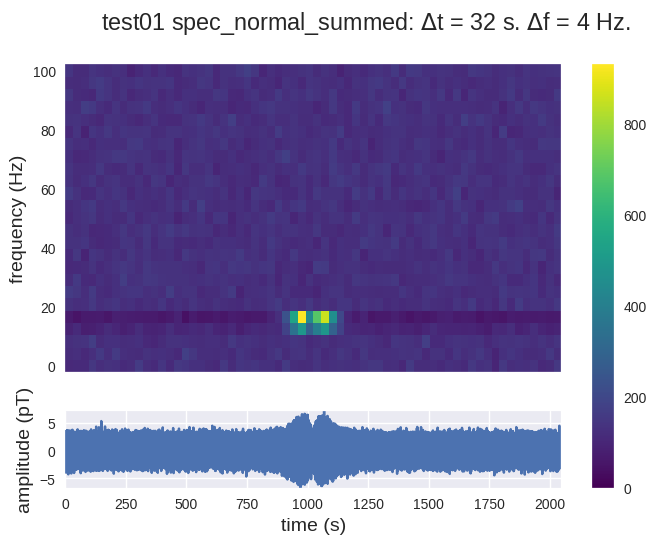

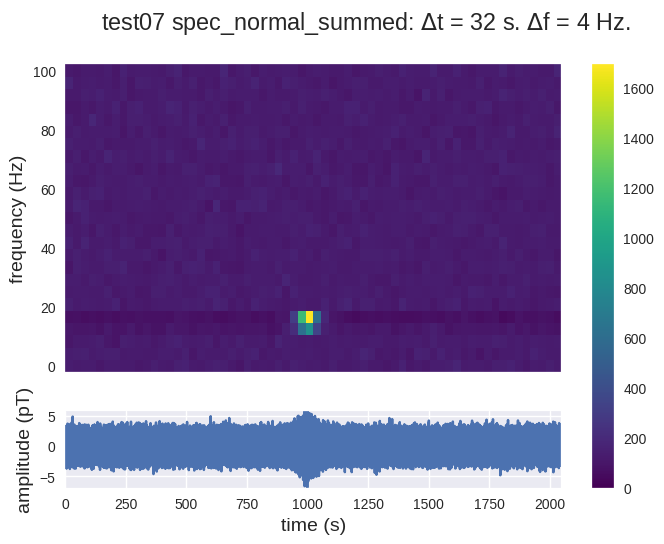

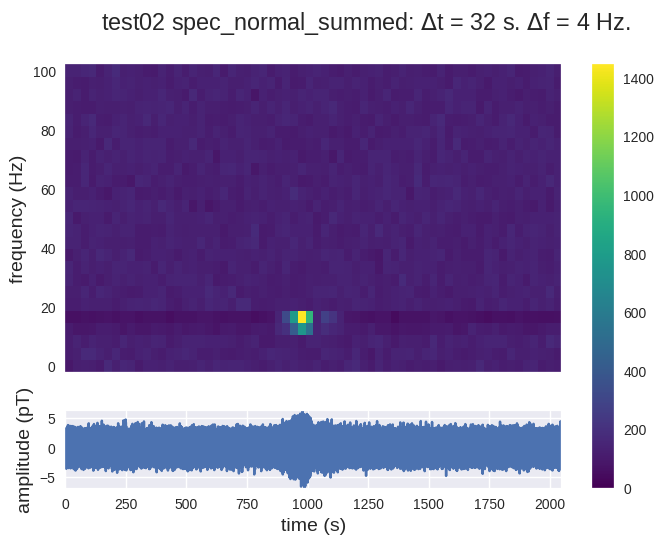

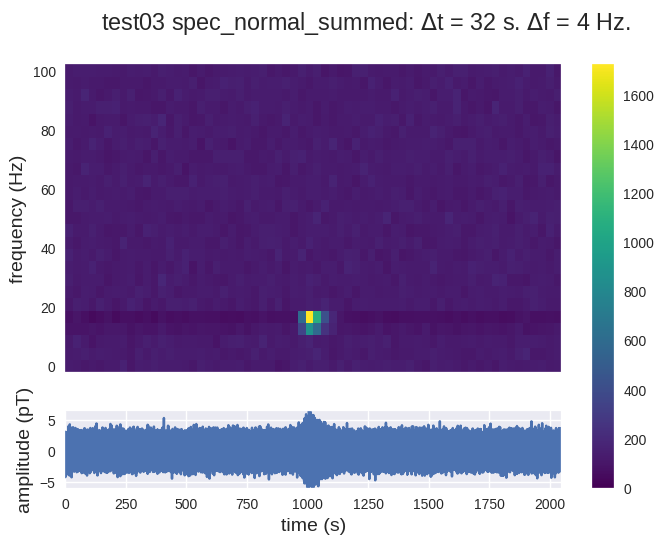

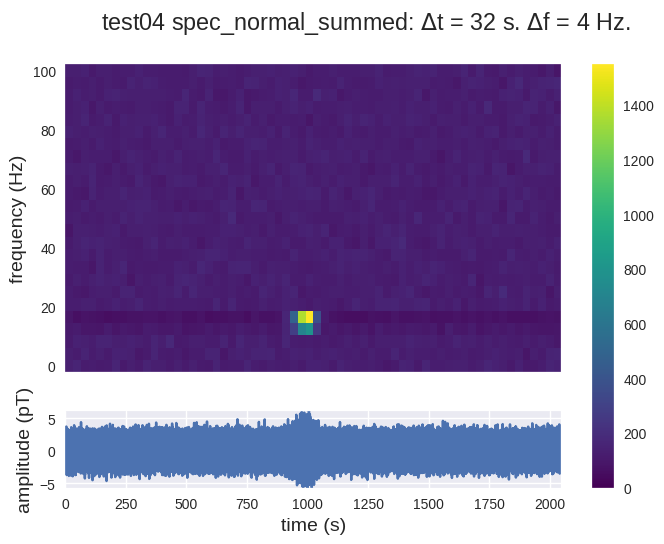

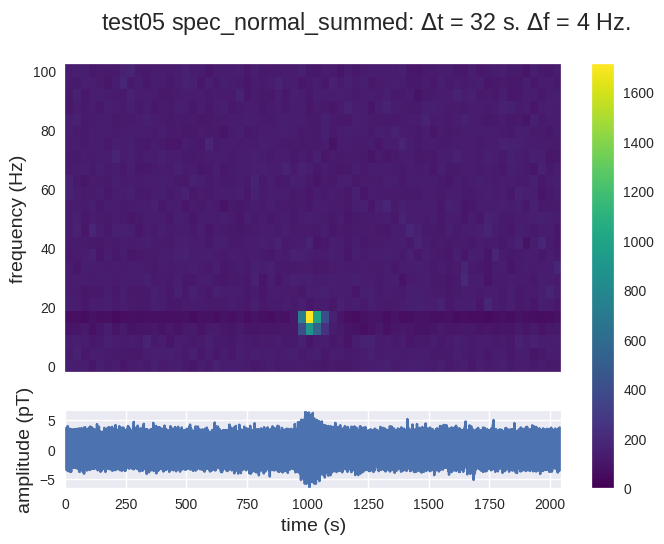

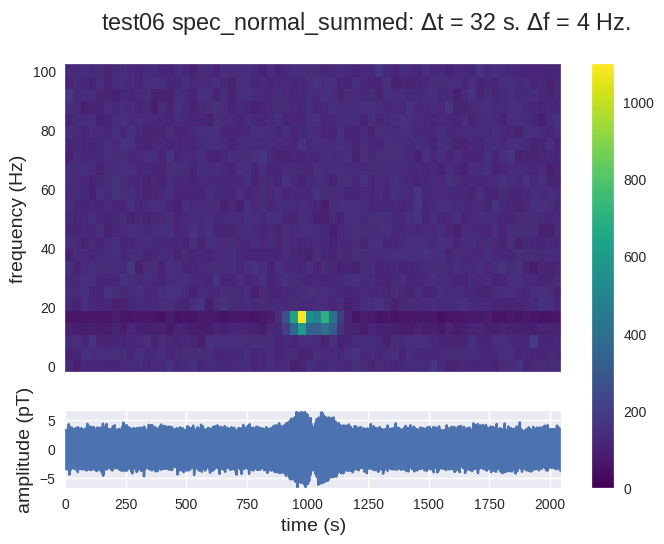

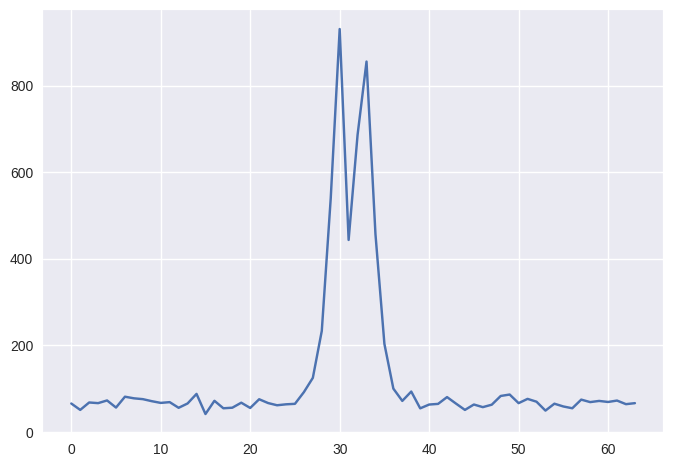

In [23]:


xtemp = random.uniform(-1, 1)
ytemp = random.uniform(-1, 1)
ztemp = random.uniform(-1, 1) 
norm_factor = np.sqrt(xtemp**2 + ytemp**2 + ztemp**2)
signal_vector_norm = [xtemp/norm_factor, ytemp/norm_factor, ztemp/norm_factor]   
i_angle_offset = [random.uniform(-1, 1),random.uniform(-1, 1),random.uniform(-1, 1)]

stat_obj_list = copy.deepcopy(STATION_OBJECT_LIST)
# injet signal
for station in stat_obj_list:
    station: EPUtils.Station
    sig = station.inject_signal(dir=[1,0,0], 
                        fsamp=FREQUENCY_SAMPLING_RATE, 
                        peak_start=1000,
                        ampl=1e8, 
                        vel=3e5, 
                        radius=6e7,
                        impact=0, 
                        freq=17, 
                        station_position=cartesian_coords[station.station], 
                        station_axis=cartesian_axes[station.station], 
                        impact_direction=i_angle_offset, 
                        plot_signal=False
                        )
    print(sig)
for station in stat_obj_list:
    station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=False)
    station.add_tiles(dt=32,df=4,verbose=False,)
    station.plot_spectrogram('spec_normal_summed', show_ts=True)

plt.plot(stat_obj_list[0].spec_normal_summed[4])


In [57]:
# rough feldman cousins procedure
ep_threshold = 2450
feldman=[]
save_data = EPUtils.DataUtils('test')

# initialize consistency mask
cmask_big: np.ndarray = np.array([])
cmask_small: np.ndarray = np.array([])
# signals = np.linspace(1e4,1e6,20)
signals = np.array([1e4,1e6])
for j in signals:
    print(j)
    total_passed_events = []
    for i in np.arange(20):
        xtemp = random.uniform(-1, 1)
        ytemp = random.uniform(-1, 1)
        ztemp = random.uniform(-1, 1) 
        norm_factor = np.sqrt(xtemp**2 + ytemp**2 + ztemp**2)
        signal_vector_norm = [xtemp/norm_factor, ytemp/norm_factor, ztemp/norm_factor]   
        i_angle_offset = [random.uniform(-1, 1),random.uniform(-1, 1),random.uniform(-1, 1)]

        stat_obj_list: list[EPUtils.Station] = copy.deepcopy(STATION_OBJECT_LIST)
        
        gen_mask= cmask_big.size == 0 # true if no mask has been created yet
        # print(gen_mask)
        
        # injet signal
        for station in stat_obj_list:
            station: EPUtils.Station
            station.inject_signal(dir=signal_vector_norm, 
                                fsamp=FREQUENCY_SAMPLING_RATE, 
                                peak_start=1000,
                                ampl=j, 
                                vel=3e5, 
                                radius=6e7,
                                impact=0, 
                                freq=17, 
                                station_position=cartesian_coords[station.station], 
                                station_axis=cartesian_axes[station.station], 
                                impact_direction=i_angle_offset, 
                                plot_signal=False,
                                generate_mask=gen_mask
                                )
        
        if gen_mask:
            for station in stat_obj_list:
                station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=False)
                station.add_tiles(dt=256,df=4,verbose=False,)
            fp_frac, cmask_big = EPUtils.mask(ep_threshold,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=True, type='spec')

            
            for station in stat_obj_list:
                station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=False)
                station.add_tiles(dt=32,df=4,verbose=False,)
            fp_frac, cmask_small = EPUtils.mask(ep_threshold/8,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=True, type='spec')
            print('generated consistency masks')

            continue
            
        for station in stat_obj_list:
            station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=False)
            station.add_tiles(dt=256,df=4,verbose=False,)
            # print(station.spec_normal_summed.shape)
            
        fp_frac, mask = EPUtils.mask(ep_threshold,stat_obj_list,NUMBER_COINCIDENCE,4,make_plot=False, type='spec')
        stat,xind,yind,mlist,x2list,passed_events = EPUtils.consistency_sum(stat_obj_list,mask,cartesian_axes,ep_threshold,verbose=False, guess=signal_vector_norm, dt=32, cmask_big=cmask_big,cmask_small=cmask_small)
        total_passed_events.append(passed_events)
        print(passed_events)
        # print(i)
    
    save_data.save_dist(total_passed_events,str(j))
    feldman.append(total_passed_events)


FC ID Generated:  44
10000.0


KeyboardInterrupt: 

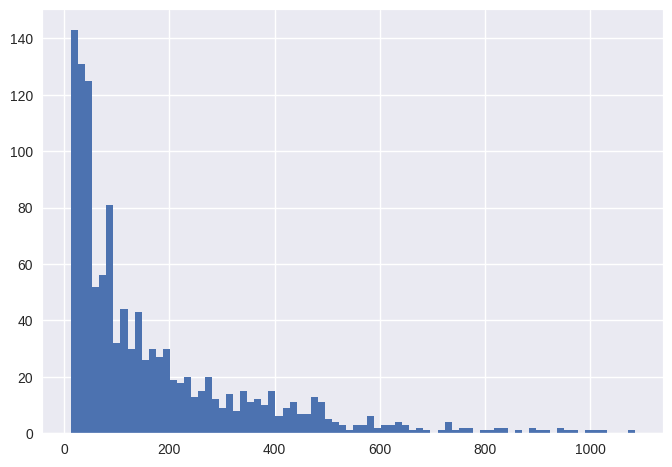

21
21


<ErrorbarContainer object of 3 artists>

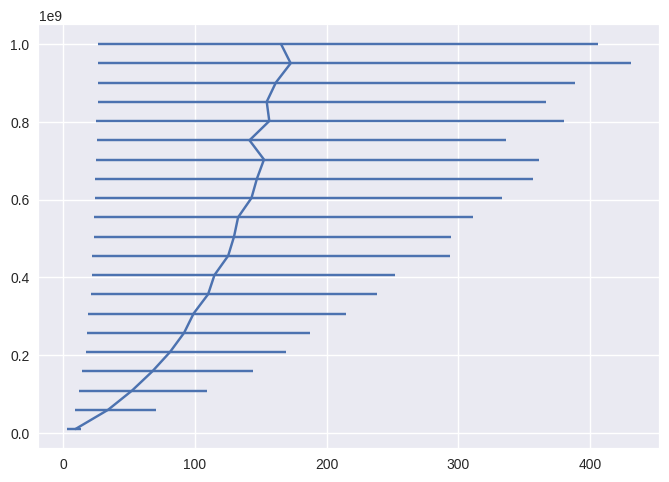

In [23]:
obj, m_data = EPUtils.load_dist('updated_masking',3)
# print(data)
# unc_data = obj.load_dist(id='unc')
# sig_data = obj.load_dist(id='sig')
sig_amp =19
plt.hist(np.concatenate(m_data[sig_amp]).flatten(),80)#,range=[0,100])
plt.show()
# plt.hist(np.concatenate(unc_data[sig_amp]).flatten(),80,range=[0,2])
# plt.show()
# plt.hist(np.concatenate(sig_data[sig_amp]).flatten(),80)#,range=[-0.0002,0.0002])
# plt.show()
# print("data_len", np.concatenate(m_data[39]).flatten().__len__())
siglist = np.linspace(1e7,1e9,21)
# data[0]
alldata=m_data
mns = []
min =[]
max=[]
for i, list in enumerate(alldata):
    list=np.concatenate(list)
    if list.size ==0:
        siglist = np.delete(siglist,i)
        continue
    list2nd = list[~np.isnan(list)]
    mean = np.mean(list[~np.isnan(list)])
    mns.append(mean)
    min.append(mean - np.percentile(list[~np.isnan(list)],10))
    max.append(np.percentile(list[~np.isnan(list)],90) - mean)
    # plt.hist(list[~np.isnan(list)],50)
print(mns.__len__())
print(siglist.__len__())

plt.errorbar(mns,siglist,None,np.array([min,max]))

In [2]:
fixed_events=np.concat(total_passed_events)
plt.hist(fixed_events.flatten(),90)
# plt.plot(mlist)
# EPUtils.desmos_parse(mlist)
# coordlist = np.transpose(mlist)
# parsed=''
# for i in range(coordlist[0].size):
#         parsed = parsed + ",({},{},{})".format(coordlist[0][i],coordlist[1][i],coordlist[2][i])

# print(parsed)

stat_obj_list[0].plot_spectrogram('spec_normal', show_ts=True)

mns = []
min =[]
max=[]
alldata=feldman

for i, list in enumerate(alldata):
    list=np.concatenate(list)
    list2nd = list[~np.isnan(list)]
    mean = np.mean(list[~np.isnan(list)])
    mns.append(mean)
    min.append(mean - np.percentile(list[~np.isnan(list)],10))
    max.append(np.percentile(list[~np.isnan(list)],90) - mean)
    # plt.hist(list[~np.isnan(list)],50)
plt.errorbar(mns,signals,None,np.array([min,max]))

NameError: name 'total_passed_events' is not defined

In [ ]:
for station in stat_obj_list:
    station: EPUtils.Station
    station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=False)
    station.add_tiles(dt=256,df=4,verbose=True,)
    # station.add_tiles(dt=16,df=4,verbose=True)
    
    # station.plot_spectrogram('spec_normal_summed', show_ts=True)
    # station.plot_spectrogram('spec_summed')
    print(station.spec_normal_summed.shape)


degrees of freedom: 2048.0
(25, 8)
degrees of freedom: 2048.0
(25, 8)
degrees of freedom: 2048.0
(25, 8)
degrees of freedom: 2048.0
(25, 8)
degrees of freedom: 2048.0
(25, 8)
degrees of freedom: 2048.0
(25, 8)


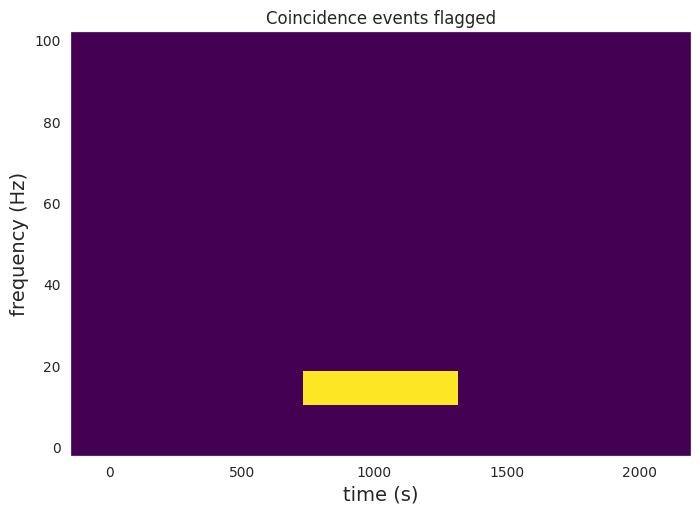

In [ ]:
# mask data
# stat_obj_list[0].plot_spectrogram('spec_normal',show_ts=True)
fp_frac, mask = EPUtils.mask(2500,stat_obj_list,NUMBER_COINCIDENCE,4,make_plot=True, type='spec')
# stat_obj_list[0].plot_spectrogram('spec_normal', show_ts=True)

/home/user/anaconda3/envs/lalsuite-dev/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/user/anaconda3/envs/lalsuite-dev/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


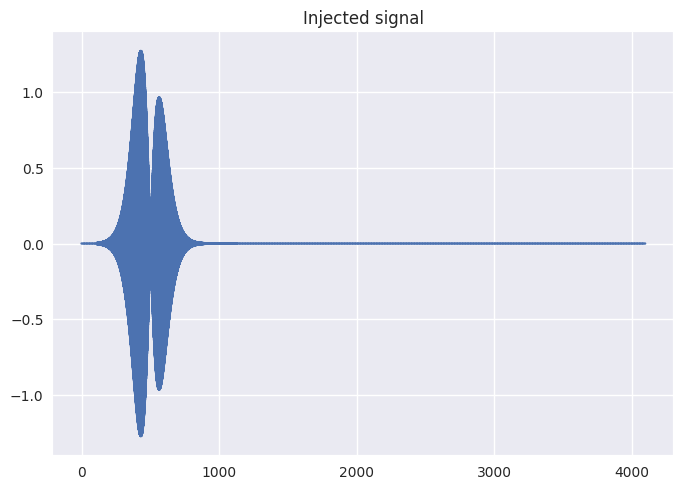

KeyboardInterrupt: 

In [ ]:
ep_threshold = 130

listofstats = []
for i in np.arange(20,40):
    
    xtemp = random.uniform(-1, 1)
    ytemp = random.uniform(-1, 1)
    ztemp = random.uniform(-1, 1) 
    norm_factor = np.sqrt(xtemp**2 + ytemp**2 + ztemp**2)
    
    
    # signal_vector = [burst_amplitude*xtemp/norm_factor, burst_amplitude*ytemp/norm_factor, burst_amplitude*ztemp/norm_factor]
    signal_vector_norm = [xtemp/norm_factor, ytemp/norm_factor, ztemp/norm_factor]
    # signal_vector_norm=[1,0,0]
    i_angle_offset = [random.uniform(-1, 1),random.uniform(-1, 1),random.uniform(-1, 1)]
    
    ## FOR SPHERICAL COORDINATES ##
    # this should not be used as it does not provide an even distribution of x,y,z coordinate points
    
    # phi = random.random()*np.pi
    # theta = random.random()*np.pi*2
    # signal_vector = [burst_amplitude*np.sin(phi)*np.cos(theta),burst_amplitude*np.sin(phi)*np.sin(theta),burst_amplitude*np.cos(phi)]
    # signal_vector_norm = [np.sin(phi)*np.cos(theta),np.sin(phi)*np.sin(theta),np.cos(phi)]

    cartesian_axes, cartesian_coords = EPUtils.coord_transform(STATION_SENSITIVE_AXES)
    
    sta_times,data_list, sanity_list, station_arr, starts, ends, STATION_OBJECT_LIST = EPUtils.load_data(start_date, end_date, STATION_LIST, STATION_STANDARD_DEVIATIONS, FREQUENCY_SAMPLING_RATE,
                                                                                                filepath=filepath,
                                                                                                shift_time=None,
                                                                                                # burst_ampl=5e18,
                                                                                                burst_ampl=3e19,
                                                                                                burst_freq=53,
                                                                                                burst_dur=256,
                                                                                                burst_start=512,
                                                                                                station_axes=cartesian_axes,
                                                                                                station_positions=cartesian_coords,
                                                                                                signal_vec=signal_vector_norm,
                                                                                                velocity=3e5,
                                                                                                impact=0.5,
                                                                                                i_angle=i_angle_offset,
                                                                                                radius=6e7
                                                                                                )

    stat_obj_list = copy.deepcopy(STATION_OBJECT_LIST)
    for station in stat_obj_list:
        station: EPUtils.Station
        station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=True)
    
    stat_obj_list.append(signal_vector_norm)
    stat_obj_list.append(i_angle_offset)
    # with open(filepath+'7-17-50-stations/injection-{}.pkl'.format(i),'wb') as f:
    # with open(filepath+'7-29-50-stations/injection-{}.pkl'.format(i),'wb') as f:
    #     pickle.dump(stat_obj_list,f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    
    

In [ ]:
# load data and calculate m
with open(filepath+'7-17-50-stations/injection-19.pkl','rb') as f:
        m_data = pickle.load(f)
        offset_directions = m_data.pop()
        signal_vector = m_data.pop()
        stat_obj_list = m_data

for station in stat_obj_list:
        station: EPUtils.Station
        station.add_tiles(dt=16,df=4,verbose=True)
        # station.add_tiles(dt=256,df=4,verbose=True)
        
stat_obj_list[3].plot_spectrogram("spec_summed",show_ts = True)
stat_obj_list[3].plot_spectrogram("spec_normal_summed",show_ts = True)
stat_obj_list[5].plot_spectrogram("spec_normal_summed",show_ts = True)
stat_obj_list[2].plot_spectrogram("spec_normal_summed",show_ts = True)
stat_obj_list[3].plot_spectrogram("spec_normal_summed",show_ts = True)

for station in stat_obj_list:
        plt.plot(station.spec_normal_summed[13],)
plt.show()
coin_mask = np.zeros(stat_obj_list[0].spec_summed.shape)
# coin_mask[13][23:35] =1
coin_mask[13] =1
fp_frac, mask = EPUtils.mask(160,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=True)

stat,xind,yind,mlist,x2list,passed_events = EPUtils.consistency(stat_obj_list,mask,cartesian_axes,140,signal_vector,verbose=True,consistency_mask=coin_mask)

plt.plot(mlist)
fig, ax = plt.subplots()
ax = fig.add_subplot(projection='3d')
coordlist = np.transpose(mlist)
ax.scatter(coordlist[0],coordlist[1],coordlist[2])
ax.scatter([signal_vector[0]],[signal_vector[1]],[signal_vector[2]])
ax.scatter([0],[0],[0])
print(signal_vector)

parsed = ''
for i in range(coordlist[0].size):
        parsed = parsed + ",({},{},{})".format(coordlist[0][i],coordlist[1][i],coordlist[2][i])

print(parsed)


# veclst.extend(passed_events)
# print(passed_events)
# x2.extend(x2list)
# ms.append(np.array(mlist))
# print('{}: {}'.format(i,s))


In [ ]:
signals = np.linspace(.01,0.25,20)
signals = np.append(signals, np.linspace(.3,.5,5))
print(signals)
mins = []
maxs = []
means = []

alldata = []
mlists = []

tilesum = []
station_objects = []

# for s in signals:
for s in np.array([0,.1,.5]):
# for s in np.array([0,.1,.3,.5,5,10,20]):

    burst_amplitude = 2
    ep_threshold = 130
    veclst = []
    x2 = []
    ms =[]
    for i in range(50):
        
        xtemp = random.uniform(-1, 1)
        ytemp = random.uniform(-1, 1)
        ztemp = random.uniform(-1, 1) 
        norm_factor = np.sqrt(xtemp**2 + ytemp**2 + ztemp**2)
        signal_vector = [burst_amplitude*xtemp/norm_factor, burst_amplitude*ytemp/norm_factor, burst_amplitude*ztemp/norm_factor]
        signal_vector_norm = [xtemp/norm_factor, ytemp/norm_factor, ztemp/norm_factor]
        # signal_vector_norm=[1,0,0]
        i_angle_offset = [random.uniform(-1, 1),random.uniform(-1, 1),random.uniform(-1, 1)]
        
        ## FOR SPHERICAL COORDINATES ##
        # this should not be used as it does not provide an even distribution of x,y,z coordinate points
        
        # phi = random.random()*np.pi
        # theta = random.random()*np.pi*2
        # signal_vector = [burst_amplitude*np.sin(phi)*np.cos(theta),burst_amplitude*np.sin(phi)*np.sin(theta),burst_amplitude*np.cos(phi)]
        # signal_vector_norm = [np.sin(phi)*np.cos(theta),np.sin(phi)*np.sin(theta),np.cos(phi)]

        cartesian_axes, cartesian_coords = EPUtils.coord_transform(STATION_SENSITIVE_AXES)
        
        sta_times,data_list, sanity_list, station_arr, starts, ends, stat_obj_list = EPUtils.load_data(start_date, end_date, STATION_LIST, STATION_STANDARD_DEVIATIONS, FREQUENCY_SAMPLING_RATE,
                                                                                                    filepath=filepath,
                                                                                                    shift_time=None,
                                                                                                    # burst_ampl=5e18,
                                                                                                    burst_ampl=5e20,
                                                                                                    burst_freq=53,
                                                                                                    burst_dur=256,
                                                                                                    burst_start=512,
                                                                                                    station_axes=cartesian_axes,
                                                                                                    station_positions=cartesian_coords,
                                                                                                    signal_vec=signal_vector_norm,
                                                                                                    velocity=3e5,
                                                                                                    impact=0.5,
                                                                                                    i_angle=i_angle_offset,
                                                                                                    radius=6e7
                                                                                                    )

        for station in stat_obj_list:
            station: EPUtils.Station
            station.excess_power_init(FREQUENCY_SAMPLING_RATE, min_time_seg_length, BANDWIDTH_LIMIT, make_plot=True)
            # station.plot_spectrogram('spec')
            
            
            
            # for i in np.array([2,4,8,16,32,64,128,256,512]):
            station.add_tiles(dt=16,df=4,verbose=False)
                
            #     station.plot_spectrogram('spec_normal_summed')
            #     tilesum.append(station.spec_normal_summed[24][0])                
            # fig, ax = plt.subplots()
            # ax.plot(tilesum)
            # ax.set_yscale('log')
            # plt.show()
                
            # itm = station.spec_normal_summed.ravel()
            # print(itm)
            # plt.hist(2*station.spec_normal_summed.ravel()[8:],50)
            # plt.hist(2*station.spec_normal_summed.ravel()[:8],10)
            
            # plt.show()
            # print('mean excess power: {}'.format(np.mean(station.spec_normal_summed)*2))
            # print('mean excess power for calc spec: {}'.format(np.mean(station.calc)*2))
            # station.plot_spectrogram('spec_normal')
            # station.plot_spectrogram('calc')
            # print(np.mean(station.spec_normal))
        # break
        coin_mask = np.zeros(stat_obj_list[0].spec_summed.shape)
        # coin_mask[49][:8] =1
        fp_frac, mask = EPUtils.mask(ep_threshold,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=False)
        # plt.plot(fp_frac)
        # plt.show()
        # stat_obj_list[0].plot_spectrogram()
        # break
        stat,xind,yind,mlist,x2list,passed_events = EPUtils.consistency(stat_obj_list,mask,cartesian_axes,ep_threshold,signal_vector,verbose=True,consistency_mask=coin_mask)
        veclst.extend(passed_events)
        print(passed_events)
        x2.extend(x2list)
        ms.append(np.array(mlist))
        print('{}: {}'.format(i,s))
        # alldata.append([stat,xind,yind,mlist,x2list,passed_events])
        # for station in stat_obj_list:
        #     plt.plot(station.subtracted[49])
        # stat_obj_list[0].plot_spectrogram('spec_normal_summed')
        # plt.imshow(coin_mask,'viridis')
    # plt.hist(veclst,50)
    # plt.show()
    veclst = np.array(veclst)
    alldata.append(veclst[~np.isnan(veclst)])
    mean = np.mean(veclst[~np.isnan(veclst)])
    means.append(mean)
    try:
        mins.append(mean - np.percentile(veclst[~np.isnan(veclst)],10))
        maxs.append(np.percentile(veclst[~np.isnan(veclst)],90)-mean)
    except:
        mins.append(0)
        maxs.append(0)
    # with open(filepath+'ep130LargeSetCheckpoint_{}.pkl'.format(s),'wb') as f:
    #     pickle.dump(alldata,f)
    print(s)
    
    mlists.append(ms)
    
    

# plt.errorbar(means,signals,None,np.array([mins,maxs]))



# with open(filepath+'ep130LargeSet.pkl','wb') as f:
#     pickle.dump(alldata,f)



# # print(stat)
# # print(xind)
# # print(mlist)
# plt.hist(veclst,50)
# # plt.hist(x2,50)
# print(np.mean(veclst))



In [ ]:
# mns = []
# min =[]
# max=[]
# import pickle
# with open(filepath+'ep170.pkl','rb') as f:
#     alldata = pickle.load(f)

# for i, list in enumerate(alldata):
#     list = np.array(list)
#     list2nd = list[~np.isnan(list)]
#     mns.append(np.mean(list[~np.isnan(list)]))
#     min.append(np.percentile(list[~np.isnan(list)],10))
#     max.append(np.percentile(list[~np.isnan(list)],90))
#     # plt.hist(list[~np.isnan(list)],50)
# plt.errorbar(mns,signals,None,np.array([min,max]))
# print("\nData type:", np.array(alldata[1]).dtype)
# print("Contains NaN:", np.isnan(alldata[1]).any())
# print("Contains inf:", np.isinf(alldata[1]).any())

In [ ]:

# load in data
axes_directions = []
offset_directions = []
station_data = []


for i in range(50):
    with open(filepath+'7-17-50-stations/injection-{}.pkl'.format(i),'rb') as f:
        m_data = pickle.load(f)
        offset_directions.append(m_data.pop())
        axes_directions.append(m_data.pop())
        station_data.append(m_data)
        print(i)
        

        for station in stat_obj_list:
            station: EPUtils.Station
            station.add_tiles(dt=16,df=4,verbose=False)
                

        coin_mask = np.zeros(stat_obj_list[0].spec_summed.shape)
        coin_mask[11][23:35] =1
        fp_frac, mask = EPUtils.mask(ep_threshold,stat_obj_list,NUMBER_COINCIDENCE,0,make_plot=False)

        stat,xind,yind,mlist,x2list,passed_events = EPUtils.consistency(stat_obj_list,mask,cartesian_axes,ep_threshold,signal_vector,verbose=True,consistency_mask=coin_mask)
        veclst.extend(passed_events)
        print(passed_events)
        x2.extend(x2list)
        ms.append(np.array(mlist))
        print('{}: {}'.format(i,s))

    veclst = np.array(veclst)
    alldata.append(veclst[~np.isnan(veclst)])
    mean = np.mean(veclst[~np.isnan(veclst)])
    means.append(mean)
    try:
        mins.append(mean - np.percentile(veclst[~np.isnan(veclst)],10))
        maxs.append(np.percentile(veclst[~np.isnan(veclst)],90)-mean)
    except:
        mins.append(0)
        maxs.append(0)

    print(s)
    
    mlists.append(ms)



In [ ]:
min = []
max = []

for m_data in alldata:
    mean = np.mean(m_data[~np.isnan(m_data)])
    min.append(mean - np.percentile(m_data[~np.isnan(m_data)],10))
    max.append(np.percentile(m_data[~np.isnan(m_data)],90) - mean)
    
plt.errorbar(means,signals,None,np.array([min,max]))

In [ ]:
list = np.array(alldata[0])
list = list[~np.isnan(list)]
mean = np.mean(list)
sorted = np.sort(list)
stdlist =[]
for i in np.linspace(0,sorted.__len__()//2-1,70):
    stdlist.append(np.std(sorted[int(i):]))

plt.plot(np.gradient(stdlist))
# plt.plot(stdlist)
sorted
# plt.hist(sorted,50)

In [ ]:
import pickle

# with open(filepath+'130epRevisedCoordinateGen.pkl'.format(1.2),'wb') as f:
#     pickle.dump(alldata,f)


In [ ]:
plt.hist(alldata[2],90)
# alldata[0]
# alldata


In [ ]:
df = 2
dt= 2
arr = np.arange(100).reshape((10,10))
print(arr)
x=np.size(arr,0)
y=np.size(arr,1)
sum = arr.reshape(x//dt,dt,y//df,df).transpose(0,2,1,3).reshape(-1,df*dt).sum(axis=1)
shape = np.reshape(sum,(x//dt,y//df))
np.repeat(np.repeat(shape,df,axis=0),dt,axis=1)

In [ ]:
matrix = np.arange(16).reshape(4,4)
dx = 2
dy =2

m, n = matrix.shape

# Ensure the dimensions are divisible by dy and dx
if m % dy != 0 or n % dx != 0:
    raise ValueError("Matrix dimensions must be divisible by tile dimensions.")

# Reshape into blocks and sum
reshaped = matrix.reshape(m // dy, dy, n // dx, dx)
summed = reshaped.sum(axis=(1, 3)) 
stretched = np.kron(summed, np.ones((dy, dx))).astype(int)
stretched


In [ ]:
m_list = mlists[0]

print(mlists[0])

# np.ravel(m_list)
plt.hist(np.sqrt(np.sum(np.square(np.vstack(m_list)),axis=1)),50)

# np.sum(np.array(m_list)**2,axis=1)


# plt.hist(np.hstack(ms)/.1,50)

In [ ]:
x=np.linspace(0,19, 20)
y=np.linspace(0,9,10)
xarr, yarr = np.meshgrid(x,y)
np.vstack([xarr.ravel(), yarr.ravel()]).reshape(20,20)

In [ ]:
xlen = 5
ylen = 5
y,x=np.meshgrid(np.arange(ylen),np.arange(xlen), indexing='ij')
# arr = np.stack((y,x),axis=-1)
x
# arr[3,4]
ma.array(y,mask=x)

In [ ]:
(x.all(1).__invert__()*x.T).T.std(1)

In [ ]:
np.sqrt(np.sum(np.arange(21).reshape(7,3)**2,axis=1))

In [ ]:
mask1 = ma.array(np.arange(5),mask=[1,1,1,0,0])
mask2 = ma.array(np.arange(5),mask=[0,0,1,1,1])

mask1.__setmask__(mask1.mask & mask2.mask)
mask1.mask

In [ ]:
print('test'.format(1.2))

In [ ]:
arr = [True, True, False, True, False, False, False, True]
arr = sanity_list[0]

arr2 = ma.array(np.arange(arr.__len__()), mask=arr).compressed()

arr2 = np.split(arr2, np.where(np.diff(arr2) != 1)[0]+1)



[array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30, 31]),
 array([3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623,
        3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631])]

In [ ]:
parsed = ''
coordlist =  []
for i in range(coordlist[0].size):
        parsed = parsed + ",({},{},{})".format(coordlist[0][i],coordlist[1][i],coordlist[2][i])

print(parsed)

In [ ]:
arr = np.arange(200).reshape((10,20))

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
         11,  12,  13,  14,  15,  16,  17,  18,  19],
       [ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39],
       [ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59],
       [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79],
       [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99],
       [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119],
       [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139],
       [140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159],
       [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
 

In [ ]:
starts = ['2021-08-28-00-01-00', '2021-08-28-00-01-00', '2021-08-28-00-01-00', '2021-08-28-00-01-00', '2021-08-28-00-01-00', '2021-08-28-00-01-00', '2021-08-28-00-01-00']
ends = ['2021-08-28-00-36-00', '2021-08-28-00-36-00', '2021-08-28-00-36-00', '2021-08-28-00-36-00', '2021-08-28-00-36-00', '2021-08-28-00-36-00', '2021-08-28-00-36-00']

data1, sanity1, file_list = getDataInRange2('lewisburg01', starts[0], ends[0], path=filepath, convert=True, sortTime=False)
data1

/GNOMEDrive/gnome/serverdata/lewisburg01/2021/08/28/


[]

In [ ]:
from gwpy.timeseries import TimeSeries,TimeSeriesList

def getDataInRange2(station, startTime, endTime, sortTime=True, convert=False, path='./', verbose=False):
    '''
    Get list of data in time range
    
    station: str
        Name of station.
    startTime: float (unix time), str
        Earliest time. String formatted as 'yyyy-mm-dd-HH-MM-SS' 
        (omitted values defaulted as 0)
    endTime: float (unix time), str
        Last time. Format same as startTime
    sortTime: bool (default: True)
        Actively sort output by start time (using data in file)
    convert: boolean (default: False)
        Whether to use conversion function from file.
    path: str (default './')
        Location of files
    verbose: bool (default False)
        Verbose output
    
    returns (data, sanity, fileList). Data and sanity are astropy TimeSeriesList
    
    Note: must evaluate values in 'sanity' (e.g., using 'value' attribute) to get boolean
    Note: use, e.g., dataTSL.join(pad=float('nan'),gap='pad') to combine 
    TimeSeriesList into single Time series.
    '''
    if(verbose):
        print('getDataInRange() --- Finding files')
    fList = gdas.getFListInRange(station, startTime, endTime, path=path)
    numFiles = len(fList)
    
    # get data
    if(verbose):
        print('getDataInRange() --- Reading files')
    dataList = [None]*numFiles
    saneList = [None]*numFiles
    for i in range(numFiles):
        dataList[i],saneList[i] = gdas.getDataFromFile(fList[i],convert=convert)
    
    # sort if needed
    if(sortTime):
        if(verbose):
            print('getDataInRange() --- Sorting data')
        # do insertion sort (likely that list is sorted)
        sortIndex = range(numFiles) # sorted list of indices
        
        for sRange in range(1, numFiles): # sRange is size of sorted segment
            # note, sortIndex[sRange] = sRange
            insPtTime = dataList[sRange].epoch # for point being inserted
            insHere = sRange # place to insert point
            while(insHere > 0 and dataList[sortIndex[insHere-1]].epoch > insPtTime): 
                insHere -= 1 # decrement until finding place to insert
            # insert point
            dummy1 = sRange # point being moved
            while(insHere <= sRange):
                dummy2 = sortIndex[insHere]
                sortIndex[insHere] = dummy1
                dummy1 = dummy2
                insHere+=1
    else:
        sortIndex = range(numFiles)
    
    # put data in TimeSeriesList
    dataTSL = TimeSeriesList()
    saneTSL = TimeSeriesList()
    for i in sortIndex:
        dataTSL.append(dataList[i])
        saneTSL.append(saneList[i])
    return dataTSL, saneTSL, [fList[i] for i in sortIndex]

In [ ]:
arr = np.array(os.listdir())
a = np.where(np.char.find(arr,".py") >= 0,arr,None)

a[a!= None]


array(['EPUtils.py', 'EPUtilsBACKUP.py',
       'feldmanCousinsMultiprocessing.py', 'gdasCode3.py'],
      dtype=object)

In [ ]:
yaw = np.linspace(0,90,2)
pitch = np.linspace(0,90,2)
roll = np.array([0])
np.array(np.meshgrid(yaw,pitch,roll)).T.reshape((-1,3)) 

array([[ 0.,  0.,  0.],
       [ 0., 90.,  0.],
       [90.,  0.,  0.],
       [90., 90.,  0.]])

In [4]:
split = np.ones(shape=(100,1000,5))

for i, item in enumerate(split):
    print(i, item)

0 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
1 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
2 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
3 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
4 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
5 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
6 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
7 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
8 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 